# 9장 컴퓨터 비전을 위한 고급 딥러닝 1부

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 9장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요 내용

- 합성곱 신경망의 주요 활용 분야(컴퓨터 비전)
    - 이미지 분류
    - 이미지 분할
    - 객체 탐지
- 합성곱 신경망 기본 아키텍처
    - 잔차 연결(residual connections)
    - 배치 정규화(batch normalization)
    - 채널 분리 합성곱(depthwise separable convolutions)
- 합성곱 신경망 학습 내용 시각화

## 9.1 컴퓨터 비전 분야 세 가지 주요 과제

컴퓨터 비전 분야에서 가장 주요한 연구 주제는 다음 세 가지이다.

- 이미지 분류(image classification): 이미지에 포함된 사물(들)의 클래스 분류
    - 단일 레이블 분류(single-label classification)
        - 예제: 고양이-강아지 분류 
    - 다중 레이블 분류(multi-label classification)
        - 예제: 구글 포토. 2만 개의 서로 다른 클래스 사용
- 이미지 분할(image segmentation): 이미지를 특정 클래스를 포함하는 영역으로 분할
    - 예제: 줌(Zoom), 구글 미트(Google Meet) 등에서 사용되는 배경 블러처리 기능
- 객체 탐지(object detection): 이미지에 포함된 객체 주의에 경계상자(bounding box) 그리기
    - 예제: 자율주행 자동차의 주변에 위치한 다른 자동차, 행인, 신호등 등 탐지 기능

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/computer_vision_tasks.png" style="width:100%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

언급된 3 분야 이외에 아래 컴퓨터 비전 분야에서도 딥러닝이 중요하게 활용된다.

- 이미지 유사도 측정(image similarity scoring),
- 키포인트 탐지(keypoint detection),
- 자세 추정(pose estimation),
- 3D 메쉬 추정(3D mesh estimation), 등등

하지만 객체 탐지를 포함해서 언급된 분야 모두
기초 수준을 넘어서기에 여기서는 다루지 않는다.
다만 객체 탐지 관련해서 다음 논문을 참고할 것을 권유한다.

- 객체 탐지 참고 자료: [RetinaNet 활용 객체 탐지](https://keras.io/examples/vision/retinanet/)

아래에서는 이미지 분할을 예제를 활용하여 좀 더 상세하게 설명한다.

## 9.2 이미지 분할 예제

### 이미지 분할 방식

이미지 분할은 크게 두 종류 방식을 사용한다.

- 시맨틱 분할(semantic segmentation): 클래스 별 분할.
    - 아래 사진 왼편: 배경과 구분된 고양이들을 묶어서 cat 클래스로 구별하지 않고 분류.
- 인스턴스 분할(instance segmentation): 클래스 및 객체 별 분할.
    - 아래 사진 오른편: 배경과 구분된 각각의 고양이를 cat1, cat2 등으로 구별해서 분류.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/instance_segmentation.png" style="width:100%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

여기서는 고양이와 강아지 사진을 이용하여 시맨틱 분할을 상세히 살펴본다.

### Oxford-IIIT 애완동물 데이터셋

[Oxford-IIIT 애완동물 데이터셋](https://www.robots.ox.ac.uk/~vgg/data/pets/)은
강아지와 고양이를 비롯해서 37종의 애완동물의 다양한 크기와 다양한 자세를 담은
7,390장의 사진으로 구성된다.

- 데이터셋 크기: 7,390
- 총 클래스 수: 37
- 클래스 별 사진 수: 약 200 장
- 사진 별 레이블: 종과 품종, 머리 표시 경계상자, 트라이맵 분할(trimap segmentation) 마스크

**트라이맵 분할 마스크**는 원본 사진과 동일한 크기의 흑백 사진이며
각각의 픽셀은 1, 2, 3 셋 중에 하나의 값을 갖는다.

- 1: 사물
- 2: 배경
- 3: 윤곽

<div align="center"><img src="https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg" style="width:100%;"></div>

그림 출처: [Oxford-IIIT 애완동물 데이터셋](https://www.robots.ox.ac.uk/~vgg/data/pets/)

**데이터셋 다운로드**

`wget`을 이용하여 사진과 레이블(annotation) 데이터셋을 다운로드한 후에
압축을 푼다.

그러면 images와 annotations 디렉토리가 생성된다.

```
annotations/
...trimaps/             # 트라이맵 분할 마스크(png 파일)
...xmls/
...README/
...list.txt/
...test.txt/
...trainval.txt/
images/                 # 훈련 이미지 데이터셋(jpg 파일)
```

In [ ]:
if 'google.colab' in str(get_ipython()):
    !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    !tar -xf images.tar.gz
    !tar -xf annotations.tar.gz
else:
    import wget, tarfile
    wget.download('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz')
    wget.download('http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz')

    for aTarfile in ['images.tar.gz', 'annotations.tar.gz']:
        with tarfile.open(aTarfile) as file:
            file.extractall('./')

### 전처리

**데이터 변환**

아래 코드는 입력 데이터로 사용될 이미지와
레이블을 넘파이 어레이로 변환하기 위해 파일들의 경로를 지정한다. 

In [4]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

10번째 이미지(9번 인덱스)를 확인해보자. 

- `load_img()` 함수: 이미지 파일 불러오기
- `img_to_array()` 함수: 이미지 파일을 어레이로 변환하기

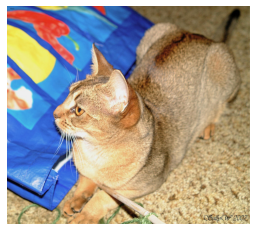

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

10번째 이미지에 대한 트라이맵 분할 마스크를 3차원 어레이로 불러오면 다음과 같다.

In [6]:
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))

이미지의 모양은 `(333, 500, 1)`이다.

In [7]:
img.shape

(448, 500, 1)

201번째 행의 트라이맵 값을 확인하면 다음과 같이
리스트 양 끝은 2로, 중앙 부분은 1로, 고양이 외곽 부분은 3으로 채워져 있다.

In [8]:
img[200]

array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],

10번째 이미지의 트라이맵 분할 마스크를 사진으로 확인하면 다음과 같다.
`display_target()` 함수는 1, 2, 3으로만 구성된 이미지를 흑백사진으로
적합한 값으로 변환한다.

- 1 => 0
- 2 => 127
- 3 => 254

여기서는 트라이맵 분할 마스크를 시각화하기 위해 사용할 뿐이며
모델 훈련에는 활용하지 않는다.

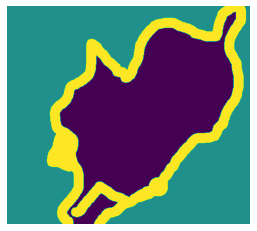

In [9]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

아래 코드에 정의되는 두 함수는 각각의 이미지 파일과 레이블을
지정된 크기의 3차원 어레이로 변환시킨다.
단, 훈련을 위해 이미지와 레이블을 무작위로 섞는다.
물론 동일한 시드(seed)를 이용해야 훈련 이미지와 레이블이 동일한 순서대로 섞이게 된다.

- 이미지 크기: `(200, 200)`

In [10]:
import numpy as np
import random

# 이미지 어레이 크기 지정
img_size = (200, 200)

# 데이터셋 크기
num_imgs = len(input_img_paths)    # 7390

# 무작위 섞기. 동일한 시드 사용.
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

# 훈련 이미지 변환 함수
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

# 레이블 변환 함수
def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1   # 0, 1, 2로 구성
    return img

데이터셋이 매우 작기에 모든 이미지와 레이블을 변환하여 하나의 4차원 어레이로 구현된
이미지 데이터셋과 타깃셋을 생성할 수 있다.

- 이미지 데이터셋 어레이 모양: `(7390, 200, 200, 3)`
- 타깃셋 어레이 모양: `(7390, 200, 200, 1)`

In [11]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [13]:
input_imgs.shape

(7390, 200, 200, 3)

In [14]:
targets.shape

(7390, 200, 200, 1)

**훈련셋과 검증셋 지정**

1,000개의 검증셋과 나머지로 구성된 훈련셋으로 분리한다. 

In [15]:
num_val_samples = 1000    # 검증셋 크기

# 훈련셋
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

# 검증셋
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

### 이미지 분할 모델 훈련

**모델 구성**

이미지 분할 모델의 구성은 기본적으로 `Conv2D` 층으로 구성된 
**다운샘플링** 블록(downsampling block)과
`Conv2DTranspose` 층으로 구성된 
**업샘플링** 블록(upsampling block)으로 이루어진다.

- 다운샘플링 블록: `Conv2D` 층 활용
    - 이미지 분류 모델과 동일한 기능.
    - 보폭(`strides=2`)을 사용하는 경우와 그렇지 않은 경우를 연속으로 적용.
        따라서 `MaxPooling2D`은 사용하지 않음.
    - 패딩(`padding="same"`)을 사용하지만 보폭을 2로 두기 때문에
        이미지 크기는 가로, 세로 모두 1/2로 줄어듦.
    - 채널 수는 동일한 방식으로 2배로 증가시킴.
- 업샘플링 블록: `Conv2DTranspose` 층 활용
    - 이미지 분할 모델의 최종 출력값은 원본 이미지의 트라이맵 분할 이미지임.
        따라서 동일한 크기의 넘파이 어레이를 출력해야 함.
    - `Conv2D` 층을 통과하면서 작아진 텐설를 원본 이미지 크기로 되돌리는 기능 수행.
    - 따라서 `Conv2D` 층이 적용된 역순으로 크기를 되돌려야 함.
    - 모델 훈련과정에서 어떤 값들을 사용하여 모양을 되돌지지 학습함.
    
**참고**: 이미지 분류의 경우와는 달리 맥스풀링을 사용하는 대신 `Conv2D` 층에서 보폭을 2로 
설정하는 이유는 픽셀에 담긴 값(정보) 뿐만 아니라 각 픽셀의 위치도 중요하기 때문이다.
맥스풀링은 이와는 달리 위치와 독립적인 패턴을 알아내는 것이 중요할 때 사용한다.

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

모델 컴파일과 훈련은 특별한 게 없다.

In [17]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 39s 326ms/step - loss: 1.0458 - val_loss: 0.9314
Epoch 2/50
100/100 [==============================] - 28s 277ms/step - loss: 0.9102 - val_loss: 0.8384
Epoch 3/50
100/100 [==============================] - 29s 292ms/step - loss: 0.8340 - val_loss: 0.8023
Epoch 4/50
100/100 [==============================] - 28s 281ms/step - loss: 0.8023 - val_loss: 0.7714
Epoch 5/50
100/100 [==============================] - 29s 292ms/step - loss: 0.7815 - val_loss: 0.7502
Epoch 6/50
100/100 [==============================] - 29s 287ms/step - loss: 0.7400 - val_loss: 0.7594
Epoch 7/50
100/100 [==============================] - 28s 281ms/step - loss: 0.6942 - val_loss: 0.7635
Epoch 8/50
100/100 [==============================] - 28s 283ms/step - loss: 0.6596 - val_loss: 0.7073
Epoch 9/50
100/100 [==============================] - 28s 283ms/step - loss: 0.6250 - val_loss: 0.7086
Epoch 10/50
100/100 [==============================] - 28s 283ms/step - l

훈련 결과를 그래프로 시각화해서 보면
과대적합이 25 에퍼크 정도에서 발생함을 확인할 수 있다. 

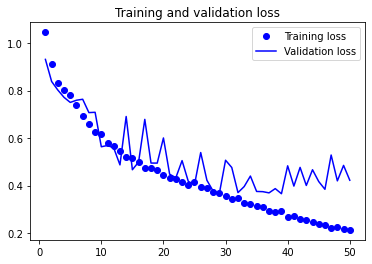

In [18]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

훈련중 저장된 최고 성능의 모델을 불러와서 이미지 분할을
어떻게 진행했는지 하나의 이미지에 대해 테스트해보면
원본 이미지에 포함된 다른 요소들 때문에 약간의 잡음이 있지만
대략적으로 이미지 분할을 잘 적용함을 알 수 있다.

- `array_to_img()` 함수: 넘파이 어레이를 이미지 파일로 변환

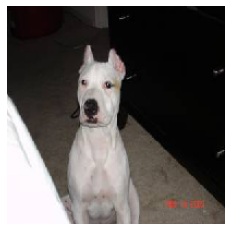

In [19]:
from tensorflow.keras.utils import array_to_img

# 최적의 모델 불러오기
model = keras.models.load_model("oxford_segmentation.keras")

# 검증셋의 4번 인덱스 이미지 확인
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

테스트 이미지에 대한 이미지 트라이맵 분할 마스크를 
이미지로 재현하면 다음과 같다.

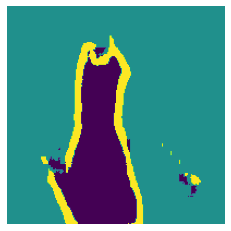

In [20]:
# 테스트 이미지의 트라이맵 분할 마스크 생성
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)